# Info

3 models are tested on bands and vegedation indices data. Model training are customised to the dataset structure, please, explore it and helper functions before to start

In [1]:
#libraries


import pandas as pd
import geopandas as gpd
import numpy as np


#clustering
from shapely import affinity
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from yellowbrick.cluster import KElbowVisualizer
#for PCA option
from sklearn.decomposition import PCA

#test/train split and hyperparameters optimisation
import random
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GroupShuffleSplit


#ML
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, IsolationForest
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, classification_report, cohen_kappa_score 
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

#stats
import scipy.stats

#visuals
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots

plt.style.use(['science', 'no-latex']) 
sns.set_style("whitegrid", {'axes.grid' : False})
plt.rcParams.update({
    "font.family": "serif",   
    "font.serif": ["Times"],  
    "font.size":9,
    "axes.labelsize":9,
    "xtick.labelsize" : 9,
    "ytick.labelsize" : 9})   
colors =[
    '#117733',
    '#50CE57',
    '#23A28F',
    '#5BD0AE',
    '#88CCEE', #water
    '#92462D', #soil
    '#DE7486',
    '#DDCC77',
    '#AA4499',
    '#0f62fe',
    '#be95ff'
]


#model saving
from joblib import dump, load

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Helpers

In [3]:
dict_normal_names = {1: 'trees', 
2: 'flooded vegetation',
3: 'open water',
4: 'settlements', 
5: 'bare soil',
6: 'agriculture', 
7: 'shrubs',
#8: 'grass'
}

In [4]:
#for getting model predictions
def get_predictions(data_scaled, 
                    model,
                    param_grid, 
                    target_column,
                    split_rate: float=0.25,
                    smote_balance: bool=True,
                    cv: int=5, 
                    n_iter_search: int=3):

    labels = data_scaled[target_column] #get label data
    indices=np.arange(data_scaled.shape[0]) #get indices numpy
    
    while True:
        train_inds, test_inds = train_test_split(indices,
                                                 test_size=split_rate, 
                                                 stratify=labels)
        train = data_scaled.iloc[train_inds]
        test = data_scaled.iloc[test_inds]
        if len(train[target_column].unique(
        )) == len(test[target_column].unique(
        )) == len(data_scaled[target_column].unique()): #because we need target feature to be represented in train and test
            break
            

    #class balansing with smote
    if smote_balance is True:
        smote = SMOTE(random_state = 42)
        X, y = smote.fit_resample(train.loc[:, train.columns!=target_column],
                                  train[target_column]) #drops 3 columns: key, class, and forest
        df_smote = pd.DataFrame(X, columns = train.loc[:, train.columns!=target_column].columns.tolist()) #drops 3 columns: key, class, and forest

        #we set train/test from SMOTE results
        X_train = df_smote
        y_train = y
        X_test = test.loc[:, train.columns!=target_column]  
        y_test = test[target_column]
        #we set train/test as it is
    else:
        X_train = train.loc[:, train.columns!=target_column]
        y_train = train[target_column]
        X_test = test.loc[:, train.columns!=target_column] 
        y_test = test[target_column]
    
    #parameters optimisation
    
    gs = RandomizedSearchCV(model, 
                            param_distributions = param_grid,
                            n_iter = n_iter_search, 
                            cv = cv, 
                            scoring= 'f1_weighted')
    gs.fit(X_train, y_train)  
    y_pred = gs.best_estimator_.predict(X_test)
    model_fit = gs.best_estimator_
    
    results = {'model': model_fit,
               'X_train data': X_train,
               'y train data':  y_train,
               'X test data': X_test,
               'y test data': y_test,
               'y predicted': y_pred
        
    }

    return results

In [43]:
def metrics_description(y_true, y_pred, 
                        metrics_by_class: bool=True, 
                        confusion_matrix_multiclass_on: bool=True,
                        binary_matrix_on: bool=False):

    
    print('Accuracy score: %.2f%%' %(accuracy_score(y_true, y_pred)*100))  
    print('Precision score: %.2f%%' % (precision_score(y_true, y_pred, average= 'weighted')*100))
    print('Recall score: %.2f%%' % (recall_score(y_true, y_pred, average= 'weighted')*100))
    print('F1-Score: %.2f%%'%(f1_score(y_true, y_pred, average = 'weighted')*100))
    print('Kappa score: %.2f%%'%(cohen_kappa_score(y_true, y_pred)*100))
    
    
    #dataframe with metrics by class
    if metrics_by_class is True:
        metrics_by_class = pd.DataFrame(
                {
                    'names': list(map(dict_normal_names.get, list(np.unique(y_true)))),
                    'f1_scores': f1_score(y_true, y_pred,
                               average=None).round(2).tolist(),
                    'precision_list': precision_score(y_true, y_pred, 
                                       average=None).round(2).tolist(),
                    'recall':recall_score(y_true, y_pred,
                                       average=None).round(2).tolist()
                }
            )
        display(metrics_by_class)

    #confusion matrix multiclass
    if confusion_matrix_multiclass_on is True:
        data = confusion_matrix(y_true, y_pred)
        df_cm = pd.DataFrame(data, columns=list(map(dict_normal_names.get, list(np.unique(y_true)))), 
                             index = list(map(dict_normal_names.get, list(np.unique(y_true)))))
        df_cm.index.name = 'Actual'
        df_cm.columns.name = 'Predicted'

        #confusion matrix plot
        f, ax = plt.subplots(figsize=(6, 10))
        cmap = sns.cubehelix_palette(light=1, as_cmap=True)

        sns.heatmap(df_cm, cbar=False, annot=True, cmap=cmap, square=True, fmt='.0f',
                    annot_kws={'size': 10})
        plt.title('Actuals vs Predicted')
        plt.show()
        
    #confusion matrix binary    
    if binary_matrix_on is True:
        cm = confusion_matrix(y_true, y_pred)
        print('Confusion matrix\n\n', cm)
        ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [6]:
#getting dataset with metrics by class for each random prediction
def get_classes_metrics(models_vector): #vector with model variations, y predicted and y true from the dataset
    class_metrics_dataframe = pd.DataFrame()
    count = 0 #counter of iteration

    for i in models_vector:

        count += 1 #counting
        pred = i['y predicted'] #predicted values 
        true = i['y test data'] #corresponding labels from random test set
        names_list = list(np.unique(true))

        temp = pd.DataFrame(
            {
                'iteration':[count]*len(names_list), 
                'names': list(map(dict_normal_names.get, names_list)),
                'f1_scores': f1_score(true, pred,
                           average=None).round(2).tolist(),
                'precision_list': precision_score(true, 
                                   pred, 
                                   average=None).round(2).tolist(),
                'recall':recall_score(true, 
                                   pred, 
                                   average=None).round(2).tolist()
            }
        ) #dataset for each model 

        class_metrics_dataframe = pd.concat([class_metrics_dataframe, temp], ignore_index=True)
    return class_metrics_dataframe 

In [7]:
#getting dataset with average metrics for each random prediction
def get_metrics_average(models_vector): #vector with model variations, y predicted and y true from the dataset
    average_metrics_dataframe = pd.DataFrame()
    count = 0 #counter of iteration

    for i in models_vector:

        count += 1 #counting
        pred = i['y predicted'] #predicted values 
        true = i['y test data'] #corresponding labels from random test set

        temp = pd.DataFrame(
            {
                'iteration':[count],#*len(names_list), 
                #'names': list(map(dict_normal_names.get, names_list)),
                'f1_scores': f1_score(true, pred,
                           average='macro').round(2).tolist(),
                'precision_list': precision_score(true, 
                                   pred, 
                                   average='weighted').round(2).tolist(),
                'recall':recall_score(true, 
                                   pred, 
                                   average='weighted').round(2).tolist()
            }
        ) #dataset for each model 

        average_metrics_dataframe = pd.concat([average_metrics_dataframe, temp], 
                                              ignore_index=True)
    return average_metrics_dataframe 

In [8]:
def get_best_model(datavector_models):
    number = get_metrics_average(datavector_models).sort_values(by='f1_scores', 
                                                                ascending=False).head(1)['iteration'].values[0]
    best_model = datavector_models[number]['model']
    return best_model

In [38]:
def get_worst_model(datavector_models):
    number = get_metrics_average(datavector_models).sort_values(by='f1_scores', 
                                                                ascending=False).tail(1)['iteration'].values[0]
    best_model = datavector_models[number]['model']
    return best_model

# Data preparation

In [9]:
df = pd.read_csv('data/general.csv')

In [10]:
x = df.loc[:, df.columns!='id'].values #returns values as a numpy array
min_max_scaler = preprocessing.MinMaxScaler() #minmax scaling
x_scaled = min_max_scaler.fit_transform(x)
df_scaled = pd.DataFrame(x_scaled, columns = list(df.loc[:, df.columns!='id'].columns))

In [11]:
df_scaled = pd.concat([df_scaled, df['id']], axis=1)

#excluding of the underrepresented class, will be fixed further
mask = df_scaled['id'] == 8
df_scaled = df_scaled[~mask]
df_scaled

,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,ndvi,evi,savi,msi,bsi,id
0,0.620500,0.396094,0.399582,0.438366,0.480756,0.355797,0.318744,0.320297,0.346736,0.379883,0.654639,0.729954,0.551893,0.817439,0.551791,0.877970,0.929606,4
1,0.618382,0.464447,0.457829,0.506182,0.529936,0.376670,0.340014,0.368400,0.377206,0.366532,0.679604,0.767464,0.552044,0.817474,0.551945,0.778298,0.884574,4
2,0.618382,0.464447,0.457829,0.506182,0.529936,0.376670,0.340014,0.368400,0.377206,0.366532,0.679604,0.767464,0.552044,0.817474,0.551945,0.778298,0.884574,4
3,0.618382,0.474962,0.459290,0.493256,0.517641,0.372376,0.343184,0.367814,0.369106,0.366532,0.648979,0.743680,0.558790,0.818079,0.558691,0.737122,0.855922,4
4,0.618382,0.474962,0.459290,0.493256,0.517641,0.372376,0.343184,0.367814,0.369106,0.366532,0.648979,0.743680,0.558790,0.818079,0.558691,0.737122,0.855922,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6235,0.096993,0.111668,0.262213,0.125890,0.453671,0.890148,0.905921,0.938502,0.923730,0.916724,0.399838,0.249796,0.969396,0.827477,0.969396,0.050277,0.086067,6
6236,0.096993,0.111668,0.262213,0.125890,0.453671,0.890148,0.905921,0.938502,0.923730,0.916724,0.399838,0.249796,0.969396,0.827477,0.969396,0.050277,0.086067,6
6237,0.096993,0.106660,0.260125,0.124391,0.437277,0.868917,0.894877,0.935765,0.905216,0.916724,0.392561,0.249796,0.969995,0.827351,0.969995,0.046889,0.079121,6
6238,0.100805,0.099649,0.214405,0.108655,0.373129,0.767056,0.797116,0.782167,0.817568,0.927703,0.374672,0.234982,0.964089,0.827770,0.964080,0.077868,0.144411,6


## Model training

### Random Forest

In [12]:
#for random forest

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# vector of 5 model iterations to evaluate average performance

datavector_rf_wf = []
for i in range(5):
    rf_model = get_predictions(data_scaled = df_scaled,
                model = RandomForestClassifier(),
                param_grid = random_grid,
                target_column = 'id', 
                smote_balance=False,
                cv=5, 
                n_iter_search=3)
    datavector_rf_wf.append(rf_model)

Accuracy score: 98.65%
Precision score: 98.67%
Recall score: 98.65%
F1-Score: 98.65%
Kappa score: 98.16%


,names,f1_scores,precision_list,recall
0,trees,0.97,0.98,0.97
1,flooded vegetation,0.92,0.93,0.91
2,open water,1.00,1.00,1.00
3,settlements,0.99,1.00,0.98
4,bare soil,0.99,0.98,1.00
5,agriculture,0.98,1.00,0.96
6,shrubs,0.94,0.92,0.96


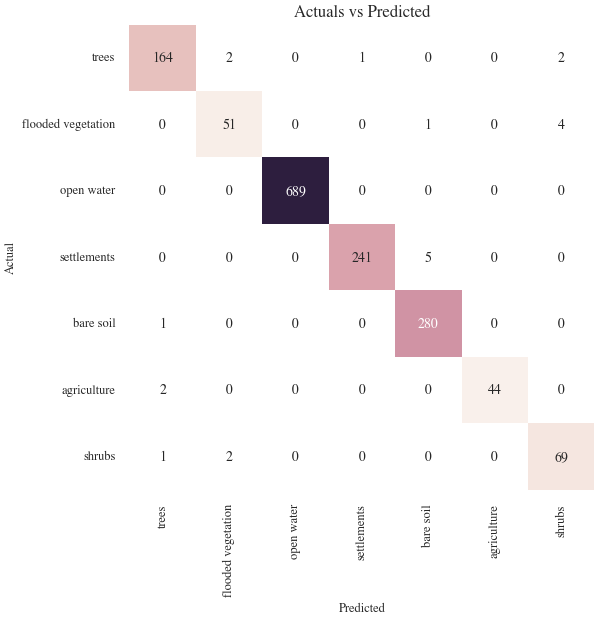

In [44]:
metrics_description(datavector_rf_wf[3]['y test data'], datavector_rf_wf[3]['y predicted'])

In [45]:
rf_class_metrics = get_classes_metrics(datavector_rf_wf)

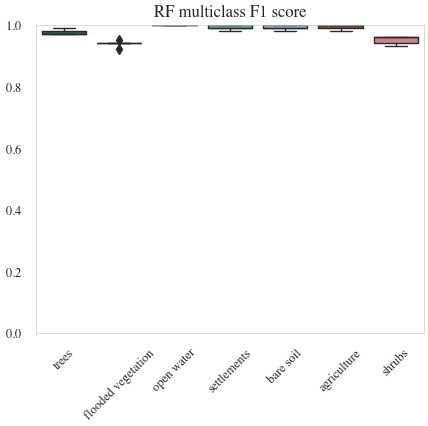

In [46]:
#f1 score plot
plt.figure(figsize=(5,4))
sns.boxplot(x = rf_class_metrics['names'],
            y = rf_class_metrics['f1_scores'], palette=colors)
plt.xlabel('')
plt.ylabel('')
plt.title('RF multiclass F1 score')
plt.xticks(rotation=45)
plt.ylim(0, 1)
#plt.savefig('RF_multiclass_F1_score.png', dpi = 300)
plt.show()

In [16]:
get_metrics_average(datavector_rf_wf)
rf_best_model = get_best_model(datavector_rf_wf)

In [39]:
rf_worst_model = get_worst_model(datavector_rf_wf)

### SVC

In [17]:
# svc random grid

svc_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'linear', 'poly']
             }

# vector of 5 model iterations to evaluate average performance

datavector_svc_wf = []
for i in range(5):
    svc_model = get_predictions(data_scaled = df_scaled,
                model = SVC(),
                param_grid = svc_grid,
                target_column = 'id', 
                smote_balance=False,
                cv=5, 
                n_iter_search=3)
    datavector_svc_wf.append(svc_model)

In [18]:
datavector_svc_wf[0].keys()

dict_keys(['model', 'X_train data', 'y train data', 'X test data', 'y test data', 'y predicted'])

Accuracy score: 96.66%
Precision score: 96.68%
Recall score: 96.66%
F1-Score: 93.89%
Kappa score: 95.44%


,names,f1_scores,precision_list,recall
0,trees,0.92,0.91,0.93
1,flooded vegetation,0.88,0.86,0.89
2,open water,1.00,1.00,1.00
3,settlements,0.96,0.96,0.96
4,bare soil,0.96,0.95,0.97
5,agriculture,1.00,1.00,1.00
6,shrubs,0.86,0.93,0.79


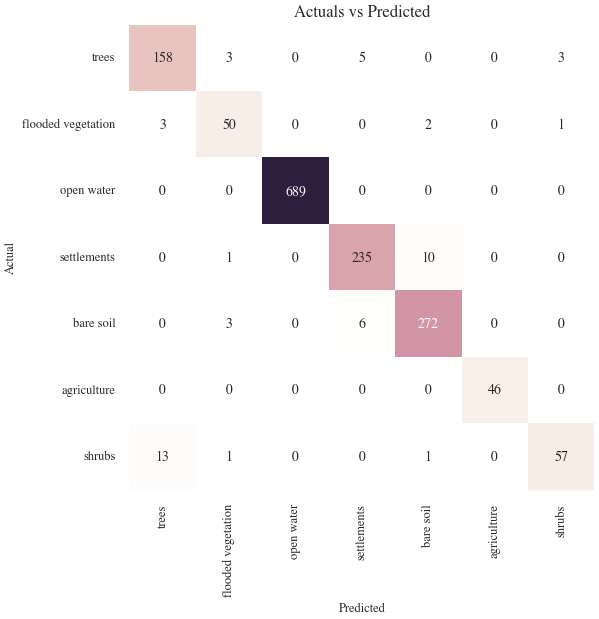

In [19]:
metrics_description(datavector_svc_wf[3]['y test data'], datavector_svc_wf[3]['y predicted'])

In [20]:
svc_class_metrics = get_classes_metrics(datavector_svc_wf)

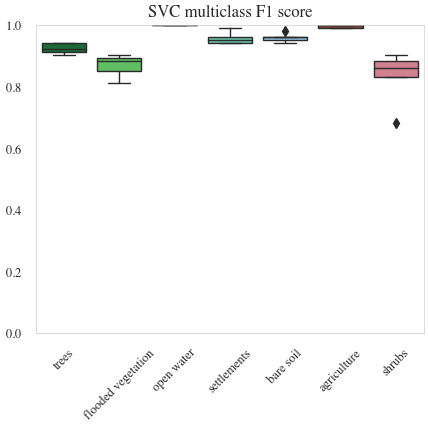

In [21]:
#f1 score plot
plt.figure(figsize=(5,4))
sns.boxplot(x = svc_class_metrics['names'],
            y = svc_class_metrics['f1_scores'], palette=colors)
plt.xlabel('')
plt.ylabel('')
plt.title('SVC multiclass F1 score')
plt.xticks(rotation=45)
plt.ylim(0, 1)
#plt.savefig('SVC_multiclass_F1_score.png', dpi = 300)
plt.show()

In [33]:
display(get_metrics_average(datavector_svc_wf))
svc_best_model = get_best_model(datavector_svc_wf)

,iteration,f1_scores,precision_list,recall
0,1,0.96,0.98,0.98
1,2,0.95,0.97,0.97
2,3,0.90,0.95,0.95
3,4,0.94,0.97,0.97
4,5,0.92,0.96,0.96


In [40]:
svc_worst_model = get_worst_model(datavector_svc_wf)

## kNN

In [27]:
#knn random grid
metric = ['euclidean','manhattan','chebyshev','minkowski']
n_neighbors = [int(x) for x in np.linspace(start = 1, stop = 100, num = 50)] 
weights = ['uniform','distance']
random_grid_knn = {
    'n_neighbors': n_neighbors,
    'weights': weights,
    'metric': metric
}

# vector of 5 model iterations to evaluate average performance on non-filtered data
datavector_knn_wf = []

for i in range(5):
    knn_model_wf = get_predictions(data_scaled=df_scaled,
                model = KNeighborsClassifier(),
                param_grid = random_grid_knn,
                target_column = 'id', 
                smote_balance=False,
                cv=5, 
                n_iter_search=3)
    datavector_knn_wf.append(knn_model_wf)

Accuracy score: 94.87%
Precision score: 95.20%
Recall score: 94.87%
F1-Score: 88.82%
Kappa score: 92.99%


,names,f1_scores,precision_list,recall
0,trees,0.90,0.93,0.88
1,flooded vegetation,0.66,0.63,0.68
2,open water,1.00,1.00,1.00
3,settlements,0.94,0.97,0.92
4,bare soil,0.96,0.95,0.96
5,agriculture,0.99,1.00,0.98
6,shrubs,0.77,0.70,0.85


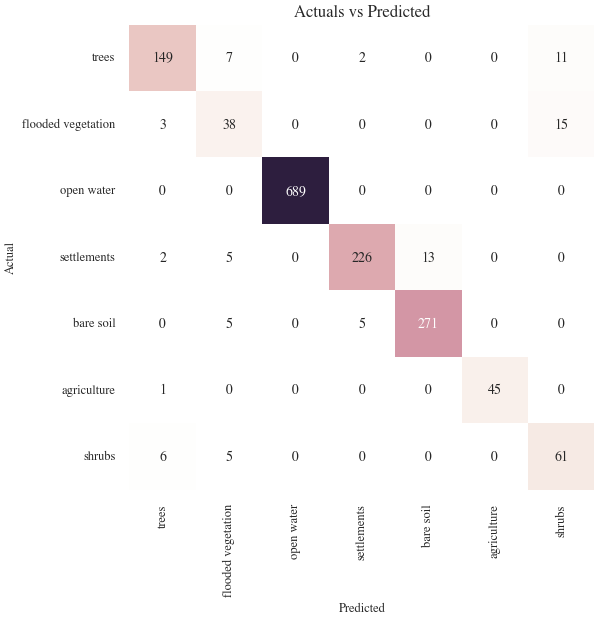

In [28]:
metrics_description(datavector_knn_wf[3]['y test data'], datavector_knn_wf[3]['y predicted'])

In [29]:
knn_class_metrics = get_classes_metrics(datavector_knn_wf)

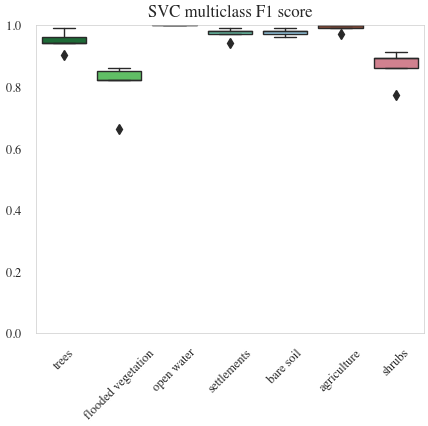

In [30]:
#f1 score plot
plt.figure(figsize=(5,4))
sns.boxplot(x = knn_class_metrics['names'],
            y = knn_class_metrics['f1_scores'], palette=colors)
plt.xlabel('')
plt.ylabel('')
plt.title('SVC multiclass F1 score')
plt.xticks(rotation=45)
plt.ylim(0, 1)
#plt.savefig('SVC_multiclass_F1_score.png', dpi = 300)
plt.show()

In [32]:
display(get_metrics_average(datavector_knn_wf))
knn_best_model = get_best_model(datavector_knn_wf)

,iteration,f1_scores,precision_list,recall
0,1,0.96,0.99,0.99
1,2,0.95,0.98,0.98
2,3,0.95,0.97,0.97
3,4,0.89,0.95,0.95
4,5,0.94,0.98,0.97


In [41]:
knn_worst_model = get_worst_model(datavector_knn_wf)

# Saving models

In [47]:
dump(svc_best_model, 'svc_best_model.joblib')
dump(rf_best_model, 'rf_best_model.joblib')
dump(knn_best_model, 'knn_best_model.joblib')

['knn_best_model.joblib']

In [48]:
dump(svc_worst_model, 'svc_worst_model.joblib')
dump(rf_worst_model, 'rf_worst_model.joblib')
dump(knn_worst_model, 'knn_worst_model.joblib')

['knn_worst_model.joblib']